# Exploring SCP alternatives under Quadratic Recourse

In [3]:
using Distributions, JuMP, Gurobi, Plots, ProgressMeter, StatsBase
gurobi_env = Gurobi.Env();

Academic license - for non-commercial use only - expires 2021-11-06


In [10]:
function piecewise_linear(x,cuts)
    #cut esta dado por [valor en nodo, pendiente, nodo]
    return maximum([cut[1]+cut[2]*(x-cut[3]) for cut in cuts])
end

V(x,q,θ) = q*(θ-x)^3/(3*θ)

V (generic function with 1 method)

In [16]:
p = 1.0 #day ahead price
q = 0.1 #same day price
θ = 100.0

#condicion inicial de stock
stock_ini=0.0;

## Classic Stochastic Cutting Plane

In [17]:
#array de vectores de cuts. Arranca en la lower bound
cuts = [[0.0;0.0;0.0]];

#aca guardo solo los multiplicadores (para ver lo que pasa)
duals = [0.0];

#estados explorados
states = [0.0];

#aca guardo los ruidos que fueron saliendo
noises = Array{Float64}(undef,0);

#condicion inicial de stock
stock_ini=0.0;

#inicializo la animacion para ir viendo los cortes paso a paso
anim=Animation()

@showprogress 1 "Computing..." for l=1:200
    
    #Forward Step (IDEM SDDP)
    model = JuMP.Model(optimizer_with_attributes(() -> Gurobi.Optimizer(gurobi_env), "OutputFlag" => 0))
    @variable(model,u0>=0);
    @variable(model,x0>=0);
    @variable(model,z);

    for i=1:length(cuts)
        cut=cuts[i]
        @constraint(model,z>=cut[1]+cut[2]*(x0+u0-cut[3]));
    end

    fix_x = @constraint(model,x0.==stock_ini);

    @objective(model,Min,p*u0+z);

    optimize!(model)

    x1_value=value.(u0)+value.(x0);

    #guardo el estado explorado
    push!(states, x1_value)
    
    #Sorteo el ruido del paso
    w=rand(DiscreteUniform(0,100));
    
    #lo agrego a los observados
    push!(noises,w)

    local_cuts = [];

    #resuelvo para cada ruido observado
    for k=1:length(noises)

        model = JuMP.Model(optimizer_with_attributes(() -> Gurobi.Optimizer(gurobi_env), "OutputFlag" => 0))

        @variable(model,u1>=0);
        fix_x = @constraint(model,x1_value-noises[k]+u1.>=0);

        @objective(model,Min,q*u1^2);

        optimize!(model)

        beta = objective_value(model);
        lambda = -dual.(fix_x)
        
        #guardo el lambda
        push!(duals,lambda);
        
        push!(local_cuts,[beta;lambda;x1_value])

    end

    #Apago los cortes anteriores
    cuts = (l-1)/l*cuts;
    
    #construyo el nuevo corte y lo agrego
    new_cut = mean(local_cuts);
    push!(cuts,new_cut);
        
    #Grafico para la animacion
    x=(0:100)
    pl=plot(;xlabel="Iteracion $l",legend=:none,xlim=(0,100),ylim=(-10,100))
    plot!(pl,x,V.(x,q,θ),lw=2)
    plot!(pl,x,piecewise_linear.(x,Ref(cuts)),lw=2)
    plot!(pl,x,piecewise_linear.(x,Ref([cuts[end]])),ls=:dash)
    frame(anim)

end

Computing...100%|███████████████████████████████████████| Time: 0:00:19


┌ Info: Saved animation to 
│   fn = /home/andres/workspace/julia/sddp/newsvendor/tmp2.gif
└ @ Plots /home/andres/.julia/packages/Plots/yfzIY/src/animation.jl:114


Plots.AnimatedGif("/home/andres/workspace/julia/sddp/newsvendor/tmp2.gif")
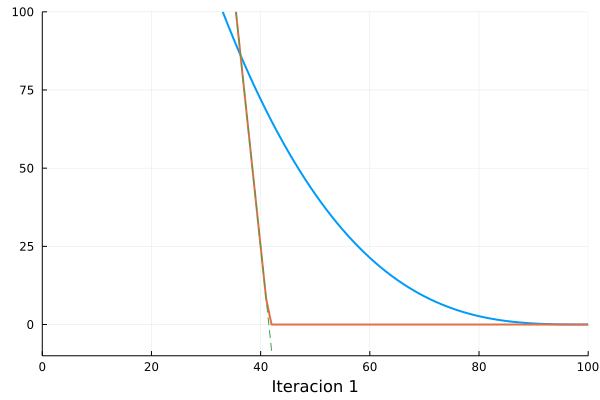

In [18]:
gif(anim,"tmp2.gif",fps=10)

In [19]:
cuts

201-element Vector{Vector{Float64}}:
 [0.0, 0.0, 0.0]
 [3.4445, -0.08300000000000007, 0.0]
 [0.861125, -0.04150000000000004, 0.415]
 [0.4305625, -0.04150000000000004, 0.9337499999999986]
 [0.14271093750000005, -0.029124999999999988, 1.452499999999999]
 [0.036014211377707675, -0.014425160944206018, 1.9381236587982837]
 [2.0726276520844564, -0.12381446287359024, 1.3888915284480736]
 [0.5913645751025626, -0.05949947437259739, 2.1875061323196983]
 [0.14817523036475633, -0.029682509701649838, 2.8975665373113384]
 [2.4169571306460367, -0.14560072563850893, 2.334593469253418]
 [0.9902866523174267, -0.09475688113891392, 3.412431188610858]
 [0.2730488450927998, -0.042502805212456266, 4.328469142662979]
 [1.652024586866459, -0.12488493051070881, 3.7333808338714918]
 ⋮
 [8.078283215830307, -0.8507872741758875, 66.53135043172956]
 [11.710498977401233, -1.0976096094654857, 63.5749418451799]
 [8.251485638414783, -0.8685846067962714, 67.71897904047708]
 [14.254693750706446, -1.2523848849701624, 62.60

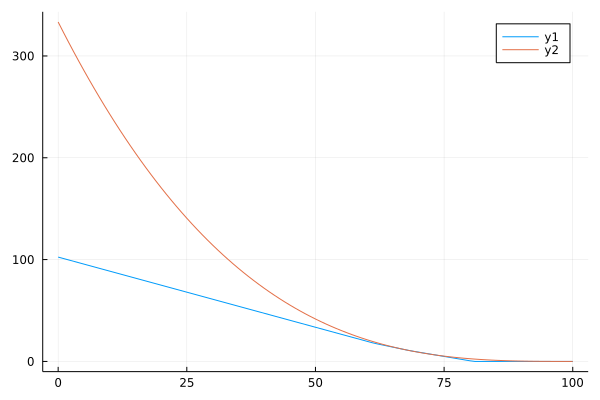

In [20]:
xx=(0:100)
plot(xx,piecewise_linear.(xx,Ref(cuts)))
plot!(xx,V.(xx,q,θ))

In [21]:
model = JuMP.Model(optimizer_with_attributes(() -> Gurobi.Optimizer(gurobi_env), "OutputFlag" => 0))
@variable(model,u0>=0);
@variable(model,x0>=0);
@variable(model,z);

for i=1:length(cuts)
    cut=cuts[i]
    @constraint(model,z>=cut[1]+cut[2]*(x0+u0-cut[3]));
end

fix_x = @constraint(model,x0.==stock_ini);

@objective(model,Min,p*u0+z);

optimize!(model)

x1_value=value.(u0)+value.(x0);
println("Stock day ahead: $x1_value.")
println("Costo estimado: $(objective_value(model)).")


Stock day ahead: 68.20044658875129.
Costo estimado: 78.91214331520945.


## Alternativa

En lugar de apagar todos los hiperplanos, solo corrijo los locales promediando con el nuevo.

In [26]:
#array de vectores de cuts. Arranca en la lower bound
cuts = [[0.0;0.0;0.0]];

#aca guardo solo los multiplicadores (para ver lo que pasa)
duals = [0.0];

#estados explorados
states = [0.0];

#aca guardo los ruidos que fueron saliendo
noises = Array{Float64}(undef,0);

#condicion inicial de stock
stock_ini=0.0;

#inicializo la animacion para ir viendo los cortes paso a paso
anim=Animation()

@showprogress 1 "Computing..." for l=1:200
    
    #Forward Step (IDEM SDDP)
    model = JuMP.Model(optimizer_with_attributes(() -> Gurobi.Optimizer(gurobi_env), "OutputFlag" => 0))
    @variable(model,u0>=0);
    @variable(model,x0>=0);
    @variable(model,z);

    for i=1:length(cuts)
        cut=cuts[i]
        @constraint(model,z>=cut[1]+cut[2]*(x0+u0-cut[3]));
    end

    fix_x = @constraint(model,x0.==stock_ini);

    @objective(model,Min,p*u0+z);

    optimize!(model)

    x1_value=value.(u0)+value.(x0);

    #guardo el estado explorado
    push!(states, x1_value)
    
    #Sorteo el ruido del paso
    w=rand(DiscreteUniform(0,100));
    
    #lo agrego a los observados
    push!(noises,w)

    local_cuts = [];

    #resuelvo para cada ruido observado
    for k=1:length(noises)

        model = JuMP.Model(optimizer_with_attributes(() -> Gurobi.Optimizer(gurobi_env), "OutputFlag" => 0))

        @variable(model,u1>=0);
        fix_x = @constraint(model,x1_value-noises[k]+u1.>=0);

        @objective(model,Min,q*u1^2);

        optimize!(model)

        beta = objective_value(model);
        lambda = -dual.(fix_x)
        
        #guardo el lambda
        push!(duals,lambda);
        
        push!(local_cuts,[beta;lambda;x1_value])

    end
    ##hasta aca solo hicimos SCP
    ## Ahora hay que ver que hacemos con los cortes
    
    #El corte nuevo es bueno, construyamoslo:
    new_cut = mean(local_cuts);

    ##Tengo que encontrar los cortes activos de los anteriores y promediarlos con el nuevo
    
    cut_values = map(c->c[1] + c[2]*(x1_value-c[3]),cuts)
    perm = sortperm(cut_values, rev=true)
    if(l>=2)
        max_cuts = cuts[perm[1:2]]

        c1 = max_cuts[1]*(l-1)/l + 1/l*new_cut
        c2 = max_cuts[2]*(l-1)/l + 1/l*new_cut

        ##cambio los activos por los promediados
        cuts[perm[1]] = c1
        cuts[perm[2]] = c2
    end
    
    #agrego el nuevo
    push!(cuts,new_cut);
        
    #Grafico para la animacion
    x=(0:100)
    pl=plot(;xlabel="Iteracion $l",legend=:none,xlim=(0,100),ylim=(-10,100))
    plot!(pl,x,V.(x,q,θ),lw=2)
    plot!(pl,x,piecewise_linear.(x,Ref(cuts)),lw=2)
    plot!(pl,x,piecewise_linear.(x,Ref([cuts[end]])),ls=:dash)
    frame(anim)

end

Computing...100%|███████████████████████████████████████| Time: 0:00:20


┌ Info: Saved animation to 
│   fn = /home/andres/workspace/julia/sddp/newsvendor/tmp2.gif
└ @ Plots /home/andres/.julia/packages/Plots/yfzIY/src/animation.jl:114


Plots.AnimatedGif("/home/andres/workspace/julia/sddp/newsvendor/tmp2.gif")
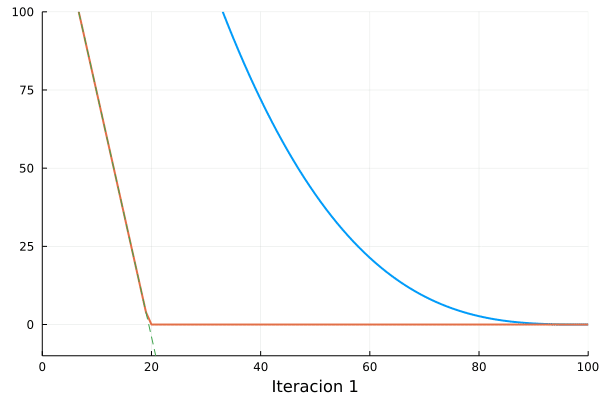

In [27]:
gif(anim,"tmp2.gif",fps=10)

In [28]:
cuts

201-element Vector{Vector{Float64}}:
 [5.390000000000002, -0.6266666666666667, 35.6973869856125]
 [85.55625, -4.875000000000001, 9.749999999999998]
 [33.96353855033819, -2.0702620967741936, 27.61491935483871]
 [18.26054818493407, -0.9949821494731306, 53.21354617585951]
 [71.72004129269274, -3.0686138851526716, 39.46607370028944]
 [2.128592321045475, -0.2030675284663325, 91.72490823818265]
 [14.831589131113232, -0.9882903777327685, 62.16946658409694]
 [25.56902507093965, -1.2087543782385388, 50.69359676165113]
 [24.118905131466764, -1.4330736616956612, 53.321487789029064]
 [20.726199663530405, -1.289983431692907, 54.475372786909595]
 [19.34274512472652, -1.1844912874217866, 53.88771781445534]
 [17.615404498526825, -1.0778596774118514, 53.8588588711741]
 [3.5624644782742334, -0.37043198310509196, 72.38704050684724]
 ⋮
 [7.366662661810049, -0.797785765313041, 73.87208244035527]
 [7.329341834202479, -0.7936908223856763, 73.87025405062208]
 [7.293126649257741, -0.7896899321758855, 73.867520

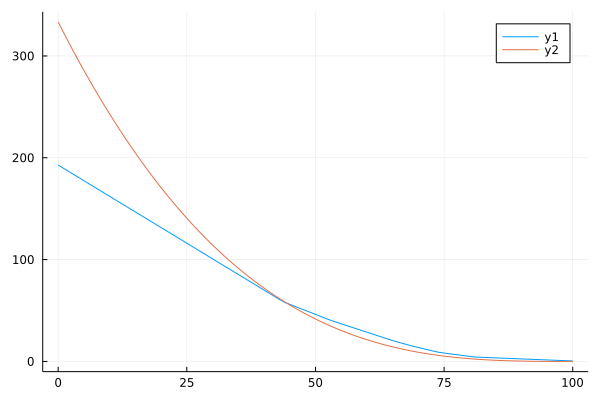

In [29]:
xx=(0:100)
plot(xx,piecewise_linear.(xx,Ref(cuts)))
plot!(xx,V.(xx,q,θ))

In [37]:
model = JuMP.Model(optimizer_with_attributes(() -> Gurobi.Optimizer(gurobi_env), "OutputFlag" => 0))
@variable(model,u0>=0);
@variable(model,x0>=0);
@variable(model,z);

for i=1:length(cuts)
    cut=cuts[i]
    @constraint(model,z>=cut[1]+cut[2]*(x0+u0-cut[3]));
end

fix_x = @constraint(model,x0.==stock_ini);

@objective(model,Min,p*u0+z);

optimize!(model)

x1_value=value.(u0)+value.(x0);
println("Stock day ahead: $x1_value.")
println("Costo estimado: $(objective_value(model)).")


Stock day ahead: 55.98480842600354.
Costo estimado: 83.71495602809046.


## Alternativa 2

* Busco los hiperplanos activos
* Recalculo el costo y lambda para el ruido nuevo y el x que genero esos dos hiperplanos
* promedio el hiperplano anterior con valores nuevos por k-1/k

In [46]:
p = 1.0 #day ahead price
q = 2.0 #same day price
θ = 100.0

#array de vectores de cuts. Arranca en la lower bound

cuts = [[0.0;0.0;0.0]];

#aca guardo solo los multiplicadores (para ver lo que pasa)
duals = [0.0];

#estados explorados
states = [];

visits = [1];

#aca guardo los ruidos que fueron saliendo
noises = Array{Float64}(undef,0);

#condicion inicial de stock
stock_ini=0.0;

#inicializo la animacion para ir viendo los cortes paso a paso
anim=Animation()

@showprogress 1 "Computing..." for l=1:150
    
    #Forward Step (IDEM SDDP)
    model = JuMP.Model(optimizer_with_attributes(() -> Gurobi.Optimizer(gurobi_env), "OutputFlag" => 0))
    @variable(model,u0>=0);
    @variable(model,x0>=0);
    @variable(model,z);

    for i=1:length(cuts)
        cut=cuts[i]
        @constraint(model,z>=cut[1]+cut[2]*(x0+u0-cut[3]));
    end

    fix_x = @constraint(model,x0.==stock_ini);

    @objective(model,Min,p*u0+z);

    optimize!(model)

    x1_value=value.(u0)+value.(x0);

    #guardo el estado explorado
    push!(states, x1_value)
    
    #Sorteo el ruido del paso
    w=rand(DiscreteUniform(0,100));
    
    #lo agrego a los observados
    push!(noises,w)

    local_cuts = [];

    #resuelvo para cada ruido observado
    for k=1:length(noises)

        model = JuMP.Model(optimizer_with_attributes(() -> Gurobi.Optimizer(gurobi_env), "OutputFlag" => 0))

        @variable(model,u1>=0);
        fix_x = @constraint(model,x1_value-noises[k]+u1.>=0);

        @objective(model,Min,q*u1^2);

        optimize!(model)

        beta = objective_value(model);
        lambda = -dual.(fix_x)
        
        #guardo el lambda
        push!(duals,lambda);
        
        push!(local_cuts,[beta;lambda;x1_value])

    end
    ##hasta aca solo hicimos SCP
    ## Ahora hay que ver que hacemos con los cortes
    
    #El corte nuevo es bueno, construyamoslo:
    new_cut = mean(local_cuts);

    ##Tengo que encontrar los cortes activos de los anteriores recalcular con el nuevo ruido
    
    cut_values = map(c->c[1] + c[2]*(x1_value-c[3]),cuts)
    perm = sortperm(cut_values, rev=true)
    if(l>=2)
        max_cuts = cuts[perm[1:2]] #estos son los cortes activos
        
        cut_viejo = max_cuts[1]
        x_viejo = cut_viejo[3]
        visits[perm[1]] = visits[perm[1]]+1; #agrego que le puse un ruido mas
        idx = visits[perm[1]];
        #resuelvo para el x del corte 1 y el ruido nuevo
        model = JuMP.Model(optimizer_with_attributes(() -> Gurobi.Optimizer(gurobi_env), "OutputFlag" => 0))
        @variable(model,u1>=0);
        fix_x = @constraint(model,x_viejo-noises[end]+u1.>=0);
        @objective(model,Min,q*u1^2);
        optimize!(model)
        beta = objective_value(model);
        lambda = -dual.(fix_x)
        
        
        c1 = max_cuts[1]*(idx-1)/idx + 1/idx*[beta;lambda;x_viejo]
        cuts[perm[1]] = c1
        
        cut_viejo = max_cuts[2]
        x_viejo = cut_viejo[3]
        visits[perm[2]] = visits[perm[2]]+1; #agrego que le puse un ruido mas
        idx = visits[perm[2]];
        #resuelvo para el x del corte 2 y el ruido nuevo
        model = JuMP.Model(optimizer_with_attributes(() -> Gurobi.Optimizer(gurobi_env), "OutputFlag" => 0))
        @variable(model,u1>=0);
        fix_x = @constraint(model,x_viejo-noises[end]+u1.>=0);
        @objective(model,Min,q*u1^2);
        optimize!(model)
        beta = objective_value(model);
        lambda = -dual.(fix_x)
        
        
        c2 = max_cuts[2]*(idx-1)/idx + 1/idx*[beta;lambda;x_viejo]
        cuts[perm[2]] = c2
        
    end
    
    #agrego el nuevo
    push!(cuts,new_cut);
    push!(visits, length(noises))
    
    #Grafico para la animacion
    x=(0:100)
    pl=plot(;xlabel="Iteracion $l",legend=:none,xlim=(0,100),ylim=(-10,100))
    plot!(pl,x,V.(x,q,θ),lw=2)
    plot!(pl,x,piecewise_linear.(x,Ref(cuts)),lw=2)
    plot!(pl,x,piecewise_linear.(x,Ref([cuts[end]])),ls=:dash)
    frame(anim)

end

Computing...100%|███████████████████████████████████████| Time: 0:00:13


In [47]:
visits

151-element Vector{Int64}:
   2
   4
   3
   7
   9
   8
   7
   7
  56
  12
  10
  11
  20
   ⋮
 139
 140
 141
 142
 143
 144
 145
 146
 147
 148
 149
 150

┌ Info: Saved animation to 
│   fn = /home/andres/workspace/julia/sddp/newsvendor/tmp2.gif
└ @ Plots /home/andres/.julia/packages/Plots/yfzIY/src/animation.jl:114


Plots.AnimatedGif("/home/andres/workspace/julia/sddp/newsvendor/tmp2.gif")
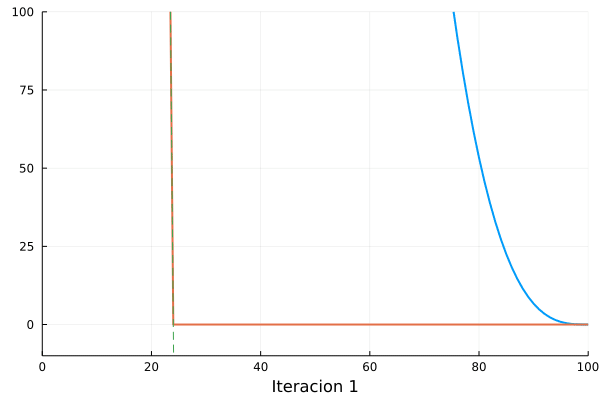

In [48]:
gif(anim,"tmp2.gif",fps=10)

In [49]:
cuts

151-element Vector{Vector{Float64}}:
 [625.0, -50.0, 0.0]
 [2429.5, -135.0, 0.0]
 [401.33333333333337, -40.0, 24.0]
 [2533.732359871032, -135.38690476190476, 0.010416666666666664]
 [2850.7634728592648, -139.95831524099, 0.010421189752496743]
 [2766.31274895168, -136.45787625349243, 0.01053093662689939]
 [2533.8403167510464, -135.39009430548896, 0.009619280770622761]
 [2533.8885763080975, -135.39152009082989, 0.009262834435381376]
 [6449.74352435838, -193.46361029328963, 0.00926283443538137]
 [4515.953098347519, -164.63313527727217, 0.008382847348631777]
 [2610.831584075312, -131.96458870698035, 0.00885282325490211]
 [3912.03335399505, -153.41749570692775, 0.009262436904426439]
 [6223.122855178143, -195.56979020652736, 0.007552448368152163]
 ⋮
 [6500.217523217177, -200.6647701876251, 0.006516202753792032]
 [6461.340259438972, -199.88840708049196, 0.006516202753792032]
 [6418.292705666834, -198.867737067077, 0.006516202753792033]
 [6394.50883842476, -198.56566803976648, 0.006516202753792

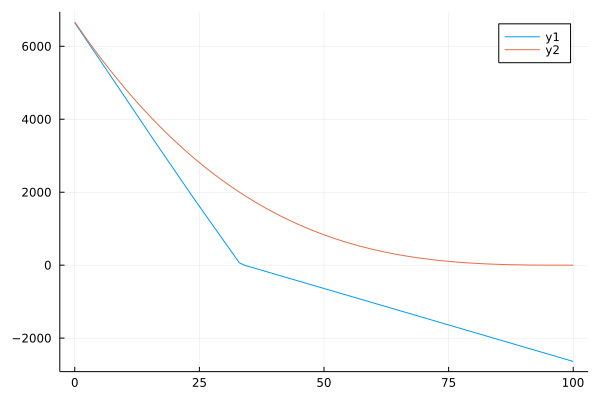

In [50]:
xx=(0:100)
plot(xx,piecewise_linear.(xx,Ref(cuts)))
plot!(xx,V.(xx,q,θ))

In [56]:
model = JuMP.Model(optimizer_with_attributes(() -> Gurobi.Optimizer(gurobi_env)))
@variable(model,u0>=0);
@variable(model,x0>=0);
@variable(model,z);

for i=1:length(cuts)
    cut=cuts[i]
    @constraint(model,z>=cut[1]+cut[2]*(x0+u0-cut[3]));
end

fix_x = @constraint(model,x0.==stock_ini);
@constraint(model,u0<=θ);
@objective(model,Min,p*u0+z);

optimize!(model)

x1_value=value.(u0)+value.(x0);
println("Stock day ahead: $x1_value.")
println("Costo estimado: $(objective_value(model)).")


Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 153 rows, 3 columns and 455 nonzeros
Model fingerprint: 0x23685229
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+02, 7e+03]
Presolve removed 2 rows and 1 columns
Presolve time: 0.00s
Presolved: 151 rows, 2 columns, 302 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0      handle free variables                          0s
       2   -2.5386667e+03   0.000000e+00   0.000000e+00      0s

Solved in 2 iterations and 0.00 seconds
Optimal objective -2.538666667e+03

User-callback calls 31, time in user-callback 0.00 sec
Stock day ahead: 100.0.
Costo estimado: -2538.6666666666665.


In [52]:
status(model)

LoadError: UndefVarError: status not defined

In [54]:
termination_status(model)

DUAL_INFEASIBLE::TerminationStatusCode = 3

In [58]:
duals

11326-element Vector{Float64}:
    0.0
 -192.0
  -96.0
   -4.0
 -191.95833333333334
  -99.95833333333333
 -115.95833333333333
 -191.95831524099
  -99.95831524099002
 -115.95831524099002
 -131.95831524099
 -191.9578762534924
  -99.9578762534924
    ⋮
 -215.97393518898483
  -91.97393518898483
  -55.97393518898483
 -155.97393518898483
  -67.97393518898483
 -139.97393518898483
  -55.97393518898483
  -35.97393518898483
  -63.97393518898483
 -235.97393518898483
  -23.973935188984832
 -111.97393518898483